In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import Dataset
from torch.utils.data import DataLoader, TensorDataset, random_split
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from taker import Model
from taker.texts import prepare

# Constants
RUN_ID = 10
LAYER_INDEX = 10
CONTEXT_LENGTH = 100
GENERATION_LENGTH = 100
TOTAL_LENGTH = CONTEXT_LENGTH + GENERATION_LENGTH
PREDICTION_LENGTH = 10
NUM_SAMPLES = 200

# File names
GENERATED_TEXTS_FILE = f'data/generated_texts-{RUN_ID}.pth'
ACTIVATIONS_FILE = f"data/activations-{RUN_ID}.pth"
PREDICTIONS_FILE = f"data/predictions-{RUN_ID}.pth"

# Load m
# m = Model("google/gemma-2b-it", dtype="hqq4_1")
m = Model("google/gemma-2b-it", dtype="fp16", limit=TOTAL_LENGTH)

# Generate texts
def generate_texts():
    ds, text_label, _ = prepare("pile")
    generated_outputs = []
    with torch.no_grad():
        for data in tqdm(ds, desc="generating texts"):
            # Generate with input ids of length up to "context_length"
            input_ids = m.get_ids(data[text_label])[:, :CONTEXT_LENGTH]
            text_in, text_out = m.generate(input_ids=input_ids, max_length=TOTAL_LENGTH)

            # check that the output is sufficiently long
            input_ids = m.get_ids(text_in+text_out)
            if input_ids.shape[1] < TOTAL_LENGTH:
                continue

            # count the number of text generated so far
            generated_outputs.append((text_in, text_out))
            if len(generated_outputs) >= NUM_SAMPLES:
                break
    return generated_outputs

# Uncomment to generate new texts
# generated_texts = generate_texts()
# print([m.get_ids(t0+t1).shape[1] for (t0, t1) in generated_texts])
# torch.save(generated_texts, GENERATED_TEXTS_FILE)

# Load generated texts
generated_texts = torch.load(GENERATED_TEXTS_FILE)
NUM_SAMPLES = len(generated_texts)

# Get activations
def get_activations(texts):
    act = {"attn_in": [], "attn_out": []}
    with torch.no_grad():
        for text in tqdm(texts):
            full_text = text[0] + text[1]  # Combine prompt and completion
            m.hooks.disable_all_collect_hooks()
            m.hooks.enable_collect_hooks(["pre_attn", "post_attn"], layers=[LAYER_INDEX])
            m.get_outputs_embeds(full_text)
            layernorm = m.layers[LAYER_INDEX]["attn.ln_in"]
            text_act = {
                "attn_in":  layernorm(m.hooks["pre_attn"]["collect", LAYER_INDEX]).cpu(),
                "attn_out": m.hooks["post_attn"]["collect", LAYER_INDEX].cpu(),
            }
            for k in act.keys():
                act[k].append(text_act[k])

    return {k:torch.cat(v, dim=0) for (k,v) in act.items()}

acts = get_activations(generated_texts)
# torch.save(acts, ACTIVATIONS_FILE)
# print(acts["attn_in"].shape, acts["attn_out"].shape)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded model 'google/gemma-2b-it' with fp16:
- Added hooks for 18 layers


100%|██████████| 200/200 [00:05<00:00, 33.85it/s]


## LoRA Implementation


In [2]:
# LoRA implementation


# copied from transformers.models.llama.modeling_llama.LlamaSdpaAttention with Llama->Mistral
# TODO @Arthur no longer copied from LLama after static cache

import math
from torch.nn import functional as F

class Lora(nn.Module):
    def __init__(self, input_dim, output_dim, rank=4, dtype=torch.float16, use_bias=False):
        super(Lora, self).__init__()
        # Low-rank matrices A and B
        self.output_dim = output_dim
        self.A = nn.Parameter(torch.Tensor(rank, input_dim ).to(dtype=dtype))
        self.B = nn.Parameter(torch.Tensor(output_dim, rank).to(dtype=dtype))
        self._reset_parameters()

    def _reset_parameters(self):
        # Initialize A with Kaiming uniform and B with zeros
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)

    def _A(self, x):
        return F.linear(input=x, weight=self.A)

    def _B(self, x):
        return F.linear(input=x, weight=self.B)

    def forward(self, x):
        # Compute only the LoRA adaptation without the standard linear component
        return self._B(self._A(x))

class LoraLinear(nn.Module):
    def __init__(self, linear, lora, use_bias=False):
        super(LoraLinear, self).__init__()
        # Low-rank matrices A and B
        self.linear = linear
        self.lora = lora
        self.bias = None
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros([self.lora.output_dim]))

    def forward(self, x):
        y = self.linear(x) + self.lora(x)
        if self.bias is not None:
            return y + self.bias
        return y

class TunedConstant(nn.Module):
    def __init__(self, value):
        super(TunedConstant, self).__init__()
        self.value = nn.Parameter(value)

    def forward(self):
        return self.value

In [3]:
# Model specific implementations
from transformers.models.mistral.modeling_mistral import MistralSdpaAttention
from transformers.models.gemma.modeling_gemma import GemmaSdpaAttention

class MistralSdpaLoraAttention(MistralSdpaAttention):
    def __init__(self, orig_attn, rank=4, dtype=torch.float16, use_bias=False):
        super(MistralSdpaLoraAttention, self).__init__(orig_attn.config)
        self.hidden_size = orig_attn.hidden_size
        self.num_heads   = orig_attn.num_heads
        self.head_dim    = orig_attn.head_dim
        self.rope_theta  = orig_attn.rope_theta
        self.is_causal   = True
        self.num_key_value_heads     = orig_attn.num_key_value_heads
        self.num_key_value_groups    = orig_attn.num_key_value_groups
        self.max_position_embeddings = orig_attn.max_position_embeddings
        self.attention_dropout       = orig_attn.attention_dropout

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )

        # Assuming orig_attn has the following attributes already initialized
        d_model = self.hidden_size
        d_kv = self.num_key_value_heads * self.head_dim
        n_kv = self.num_key_value_groups

        # load up modified attentions
        # self.q_proj_orig = orig_attn.q_proj  # Projects input to query space, size: [hidden_size, num_heads * head_dim]
        self.q_proj = LoraLinear(
            orig_attn.q_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.k_proj_orig = orig_attn.k_proj  # Projects input to key space, size: [hidden_size, num_key_value_heads * head_dim]
        self.k_proj = LoraLinear(
            orig_attn.k_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.v_proj_orig = orig_attn.v_proj  # Projects input to value space, size: [hidden_size, num_key_value_heads * head_dim]
        self.v_proj = LoraLinear(
            orig_attn.v_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.o_proj_orig = orig_attn.o_proj  # Projects concatenated outputs back to hidden_size, size: [num_heads * head_dim, hidden_size]
        self.o_proj = LoraLinear(
            orig_attn.o_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )

        self.lora_list = [
            self.q_proj.lora,
            self.k_proj.lora,
            self.v_proj.lora,
            self.o_proj.lora,
        ]
        self.bias_list = []
        if use_bias:
            self.bias_list += [
                self.q_proj.bias,
                self.k_proj.bias,
                self.v_proj.bias,
                self.o_proj.bias,
            ]

        self.rotary_emb = orig_attn.rotary_emb

    def lora_params(self):
        for component in self.lora_list:
            for param in component.parameters():
                yield param
        for bias in self.bias_list:
            yield bias


class MistralSdpaLoraAttention(MistralSdpaAttention):
    def __init__(self, orig_attn, rank=4, dtype=torch.float16, use_bias=False):
        super(MistralSdpaLoraAttention, self).__init__(orig_attn.config)
        self.hidden_size = orig_attn.hidden_size
        self.num_heads   = orig_attn.num_heads
        self.head_dim    = orig_attn.head_dim
        self.rope_theta  = orig_attn.rope_theta
        self.is_causal   = True
        self.num_key_value_heads     = orig_attn.num_key_value_heads
        self.num_key_value_groups    = orig_attn.num_key_value_groups
        self.max_position_embeddings = orig_attn.max_position_embeddings
        self.attention_dropout       = orig_attn.attention_dropout

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )

        # Assuming orig_attn has the following attributes already initialized
        d_model = self.hidden_size
        d_kv = self.num_key_value_heads * self.head_dim
        n_kv = self.num_key_value_groups

        # load up modified attentions
        # self.q_proj_orig = orig_attn.q_proj  # Projects input to query space, size: [hidden_size, num_heads * head_dim]
        self.q_proj = LoraLinear(
            orig_attn.q_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.k_proj_orig = orig_attn.k_proj  # Projects input to key space, size: [hidden_size, num_key_value_heads * head_dim]
        self.k_proj = LoraLinear(
            orig_attn.k_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.v_proj_orig = orig_attn.v_proj  # Projects input to value space, size: [hidden_size, num_key_value_heads * head_dim]
        self.v_proj = LoraLinear(
            orig_attn.v_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.o_proj_orig = orig_attn.o_proj  # Projects concatenated outputs back to hidden_size, size: [num_heads * head_dim, hidden_size]
        self.o_proj = LoraLinear(
            orig_attn.o_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )

        self.lora_list = [
            self.q_proj.lora,
            self.k_proj.lora,
            self.v_proj.lora,
            self.o_proj.lora,
        ]
        self.bias_list = []
        if use_bias:
            self.bias_list += [
                self.q_proj.bias,
                self.k_proj.bias,
                self.v_proj.bias,
                self.o_proj.bias,
            ]

        self.rotary_emb = orig_attn.rotary_emb

    def lora_params(self):
        for component in self.lora_list:
            for param in component.parameters():
                yield param
        for bias in self.bias_list:
            yield bias

class GemmaSdpaLoraAttention(GemmaSdpaAttention):
    def __init__(self, orig_attn, rank=4, dtype=torch.float16, use_bias=False):
        super(GemmaSdpaLoraAttention, self).__init__(orig_attn.config, orig_attn.layer_idx)

        self.hidden_size = orig_attn.hidden_size
        self.num_heads = orig_attn.num_heads
        self.head_dim = orig_attn.head_dim
        self.num_key_value_heads = orig_attn.num_key_value_heads
        self.num_key_value_groups = orig_attn.num_key_value_groups
        self.max_position_embeddings = orig_attn.max_position_embeddings
        self.rope_theta = orig_attn.rope_theta
        self.is_causal = orig_attn.is_causal
        self.attention_dropout = orig_attn.attention_dropout

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )

        d_model = self.hidden_size
        d_kv = self.num_key_value_heads * self.head_dim

        # Replace original projections with LoRA-enhanced versions
        self.q_proj = LoraLinear(
            orig_attn.q_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        self.k_proj = LoraLinear(
            orig_attn.k_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        self.v_proj = LoraLinear(
            orig_attn.v_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        self.o_proj = LoraLinear(
            orig_attn.o_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )

        self.rotary_emb = orig_attn.rotary_emb

    def lora_parameters(self):
        return (
            list(self.q_proj.lora.parameters()) +
            list(self.k_proj.lora.parameters()) +
            list(self.v_proj.lora.parameters()) +
            list(self.o_proj.lora.parameters()) +
            ([self.q_proj.bias] if self.q_proj.bias is not None else []) +
            ([self.k_proj.bias] if self.k_proj.bias is not None else []) +
            ([self.v_proj.bias] if self.v_proj.bias is not None else []) +
            ([self.o_proj.bias] if self.o_proj.bias is not None else [])
        )

## LoRA Fine-Tuning

In [4]:
L = m.layers[LAYER_INDEX]
x = acts["attn_in"][:1].cuda()
y = acts["attn_out"][:1].cuda()
lora_attn = GemmaSdpaLoraAttention(L["attn"]).to(m.device)

def run_attn(attn, v):
    position_ids = torch.arange(x.shape[1], device=x.device)[None, :]
    # v = m.layers[LAYER_INDEX]["attn.ln_in"] # attention input layernorm
    v = attn(v, position_ids=position_ids)[0]
    return v

def do_orig_attn(_x):
    return run_attn(L["attn"], _x)

def do_lora_attn(_x):
    return run_attn(lora_attn, _x)

with torch.no_grad():
    print("Verify original attn:", torch.equal(do_orig_attn(x), y))
    print("Verify new lora attn:", torch.equal(do_lora_attn(x), y))

Verify original attn: True
Verify new lora attn: True


In [ ]:
# SlidingWindow = 1

# Original Attention
# x0 --> y0
# x1 --> y1
# x2 --> y2
# x3 --> y3
# x4 --> y4
# x5 --> y5
# x6 --> y6

# New Attention After Training with Lora
# x0 --> z0 -- trained to match --> ~y1
# x1 --> z1 -- trained to match --> ~y2
# x2 --> z2 -- trained to match --> ~y3
# x3 --> z3 -- trained to match --> ~y4
# x4 --> z4 -- trained to match --> ~y5
# x5 --> z5
# x6 --> z6

# SlidingWindow = 2

# Original Attention
# x0 --> y0 --> (y0+y1)/2
# x1 --> y1 --> (y1+y2)/2
# x2 --> y2 --> (y2+y3)/2
# x3 --> y3 --> (y3+y4)/2
# x4 --> y4 --> (y4+y5)/2
# x5 --> y5
# x6 --> y6

# New Attention After Training with Lora
# x0 --> z0 --> (z0+z1)/2 -- trained to match --> ~(y2+y3)/2
# x1 --> z1 --> (z1+z2)/2 -- trained to match --> ~(y3+y4)/2
# x2 --> z2 --> (z2+z3)/2 -- trained to match --> ~(y4+y5)/2
# x3 --> z3 --> (z3+z4)/2 -- trained to match --> ~(y5+y6)/2
# x4 --> z4 --> (z4+z5)/2 -- trained to match --> ~(y6+y7)/2
# x5 --> z5
# x6 --> z6


In [8]:
# SET UP THE METRICS
def Angle(output, target):
    # we want angle(a,b) = small --> positive loss
    cosines = torch.nn.functional.cosine_similarity(output, target)
    angles  = torch.acos(cosines)
    return angles * 180 / math.pi

def CosSim(output, target):
    # we want cos(a,b) = high (similarity) --> negative loss
    return - torch.nn.functional.cosine_similarity(output, target)

def MSE(output, target):
    return ((output - target)**2).mean(dim=-1)

def NormedMSE(output, target):
    # We want distance to be small --> positive loss
    output = output / output.norm(keepdim=True)
    target = target / target.norm(keepdim=True)
    return ((output - target)**2).mean(dim=-1)

# SET UP WHAT THE TARGET SHOULD BE
def sliding_mean(tensor, window_size):
    cumsum = torch.cumsum(tensor, dim=1)
    return (cumsum[:, window_size:] - cumsum[:, :-window_size]) / window_size

def get_targets(attn_out):
    # [ 0, 1, 2, 3 ,4 ,5 ] -> [ 1-2, 2-3, 3-4 ]
    # maps [0,1,2,3,4,5,6,7,8,9], 2 -> [2-3, 3-4, ..., 8-9]
    return sliding_mean(attn_out[:, :, PREDICTION_LENGTH-1:], window_size=PREDICTION_LENGTH)

def get_predictions(attn_out):
    # maps [0,1,2,3,4,5,6,7,8,9], 2 -> [2-3, 3-4, ..., 8-9]
    # ["0", "1"] -> [0-1, 1-2] === [1-2, 2-3]
    return sliding_mean(attn_out[:, :, :1-PREDICTION_LENGTH], window_size=PREDICTION_LENGTH)

# SET UP THE TRAINING
def setup_training(m, acts, layer_index, rank=4):
    with torch.no_grad():
        orig_attn = m.layers[layer_index]["attn"].to("cuda")
        attn_lora = GemmaSdpaLoraAttention(orig_attn, rank=rank, use_bias=False).to("cuda").float()

        dataset = {
            "attn_in"      : acts["attn_in"].float().unbind(dim=0),
            "attn_out_orig": acts["attn_out"].float().unbind(dim=0),
            "targets"      : get_targets(acts["attn_out"]).float().unbind(dim=0),
        }
    return attn_lora, dataset

def train(attn_lora, acts_dataset, num_epochs=50, learning_rate=0.001):
    # Split dataset into [train, test]
    # print(acts["attn_in"].shape, print(acts["attn_out_orig"].shape), print(acts["targets"].shape))
    dataset = Dataset.from_dict(acts_dataset).with_format("torch")
    print("Dataset has", len(dataset), "items")
    train_size = int(0.8 * len(dataset))
    train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=32)

    # set up optimizer and criterion
    optimizer = optim.Adam(attn_lora.lora_parameters(), lr=learning_rate)
    metric    = Angle
    criterion = lambda x,y: metric(x,y).mean()

    for epoch in range(num_epochs):
        attn_lora.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            attn_out  = run_attn(attn_lora, batch["attn_in"].cuda())
            predicted = get_predictions(attn_out)
            loss = criterion(predicted, batch["targets"].cuda())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        attn_lora.eval()
        val_loss = 0
        with torch.no_grad():
            all_predicted = []
            for batch in val_loader:
                attn_out  = run_attn(attn_lora, batch["attn_in"].cuda())
                predicted = get_predictions(attn_out)
                all_predicted.append(predicted)
                loss = criterion(predicted, batch["targets"].cuda())
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    return all_predicted

attn_lora, acts_dataset = setup_training(m, acts, LAYER_INDEX, rank=10)
predicted_finetuned = train(attn_lora, acts_dataset, num_epochs=50, learning_rate=0.01)

Dataset has 200 items
Epoch 1/50, Train Loss: 82.7546, Val Loss: 77.9570


Epoch 2/50, Train Loss: 75.7708, Val Loss: 75.3680
Epoch 3/50, Train Loss: 73.5603, Val Loss: 73.8573
Epoch 4/50, Train Loss: 72.4000, Val Loss: 72.9310
Epoch 5/50, Train Loss: 71.4544, Val Loss: 72.0249
Epoch 6/50, Train Loss: 70.5044, Val Loss: 71.2780
Epoch 7/50, Train Loss: 69.5585, Val Loss: 70.5287
Epoch 8/50, Train Loss: 68.9417, Val Loss: 70.0934
Epoch 9/50, Train Loss: 68.3928, Val Loss: 69.7298
Epoch 10/50, Train Loss: 67.9720, Val Loss: 69.3473
Epoch 11/50, Train Loss: 67.5878, Val Loss: 69.0878
Epoch 12/50, Train Loss: 67.2703, Val Loss: 68.8625
Epoch 13/50, Train Loss: 66.9544, Val Loss: 68.6107
Epoch 14/50, Train Loss: 66.6487, Val Loss: 68.3613
Epoch 15/50, Train Loss: 66.3340, Val Loss: 68.0268
Epoch 16/50, Train Loss: 65.9665, Val Loss: 67.6131
Epoch 17/50, Train Loss: 65.5733, Val Loss: 67.3392
Epoch 18/50, Train Loss: 65.2925, Val Loss: 67.0646
Epoch 19/50, Train Loss: 64.9893, Val Loss: 66.7652
Epoch 20/50, Train Loss: 64.6816, Val Loss: 66.4269
Epoch 21/50, Train L

In [18]:
normed = lambda x: x / np.linalg.norm(x)

# Get predictions that original model would have given
with torch.no_grad():
    orig_attn = m.layers[LAYER_INDEX]["attn"].to("cuda")
    orig_predictions = []
    for batch in Dataset.from_dict(acts_dataset).with_format("torch"):
        attn_out  = run_attn(orig_attn, batch["attn_in"].cuda()[None])
        predicted = get_predictions(attn_out)
        orig_predictions.append(predicted[0, -1])
    orig_predictions = [normed(pred.detach().cpu()) for pred in orig_predictions]

# Get predictions that the trained model gives
with torch.no_grad():
    ft_predictions = []
    for batch in Dataset.from_dict(acts_dataset).with_format("torch"):
        attn_out  = run_attn(attn_lora, batch["attn_in"].cuda()[None])
        predicted = get_predictions(attn_out)
        ft_predictions.append(predicted[0, -1])
    ft_predictions = [normed(pred.detach().cpu()) for pred in ft_predictions]

# Combine data
full_dataset = Dataset.from_dict({
    "targets": [normed(tgt[-1]) for tgt in acts_dataset["targets"]],
    "ft_predictions": ft_predictions,
    "orig_predictions": orig_predictions,
}).with_format("numpy")

n_items = len(full_dataset)
dots = np.zeros([n_items, n_items])

numpify = lambda _name : np.array([b[_name] for b in full_dataset])
_targets        = numpify("targets")
_ft_predictions = numpify("ft_predictions")
_orig_predictions = numpify("orig_predictions")

# Get dotproducts / cossine similarity
expected_dots = _targets @ _targets.T
trained_dots  = _targets @ _ft_predictions.T
orig_dots     = _targets @ _orig_predictions.T

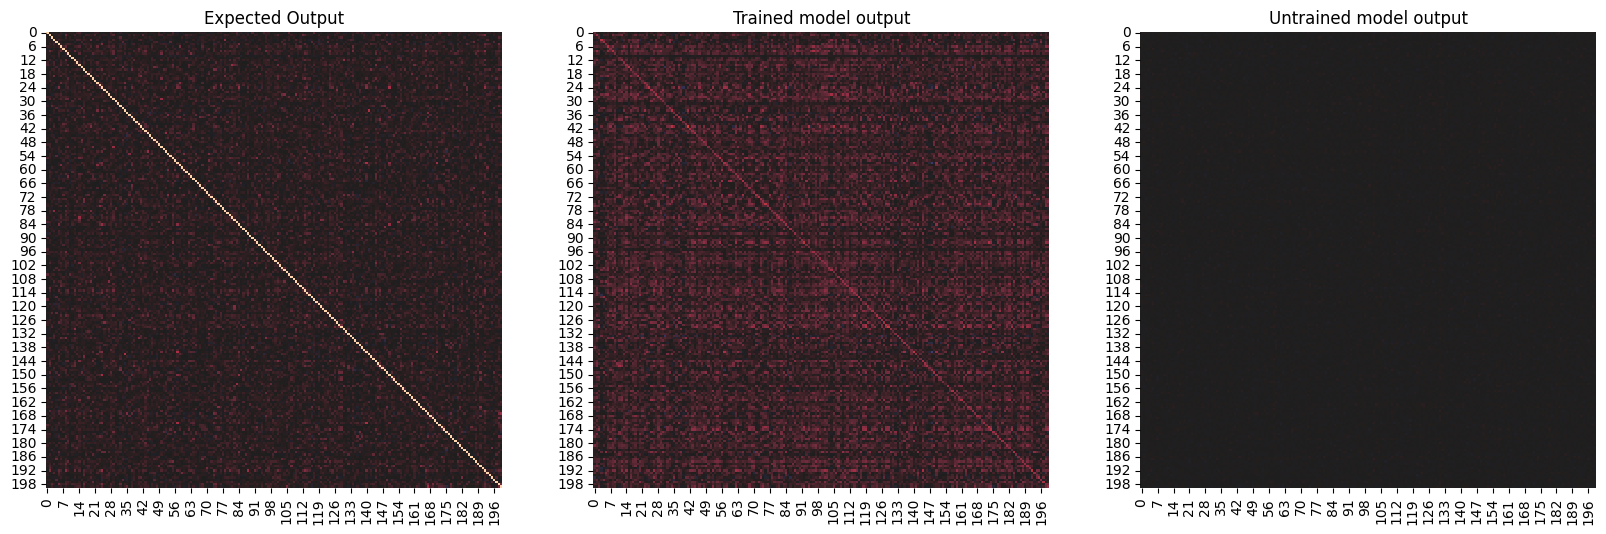

In [21]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
sns.heatmap(ax=ax1, data=expected_dots, square=True, center=0.0, vmax=1.0, cbar=False);ax1.set_title("Expected Output")
sns.heatmap(ax=ax2, data=trained_dots, square=True,  center=0.0, vmax=1.0, cbar=False);ax2.set_title("Trained model output")
sns.heatmap(ax=ax3, data=orig_dots, square=True,  center=0.0, vmax=1.0, cbar=False);ax3.set_title("Untrained model output")

plt.show()